In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, DenseNet169, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
#from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [5]:
covid19_train = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/train/covid',224))
normal_train = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/train/normal',224))
pneumonia_bacterial_train = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/train/pneumonia_bacterial',224))
pneumonia_viral_train = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/train/pneumonia_viral',224))


covid19_test = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/test/covid',224))
normal_test = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/test/normal',224))
pneumonia_bacterial_test = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/test/pneumonia_bacterial',224))
pneumonia_viral_test = np.array(Dataset_loader('/content/drive/MyDrive/4-Class Dataset/4-Class Dataset/four_classes/test/pneumonia_viral',224))

100%|██████████| 70/70 [00:17<00:00,  3.93it/s]


In [6]:
print(len(normal_train))
print(len(covid19_train))
print(len(pneumonia_bacterial_train))
print(len(pneumonia_viral_train))

print(len(normal_test))
print(len(covid19_test))
print(len(pneumonia_bacterial_test))
print(len(pneumonia_viral_test))

378
308
384
354
87
20
75
70


In [7]:
# Create labels
covid19_train_label   = np.full(len(covid19_train),0)
normal_train_label   = np.full(len(normal_train),1)
pneumonia_bacterial_train_label = np.full(len(pneumonia_bacterial_train),2)
pneumonia_viral_train_label   = np.full(len(pneumonia_viral_train),3)

covid19_test_label   = np.full(len(covid19_test),0)
normal_test_label   = np.full(len(normal_test),1)
pneumonia_bacterial_test_label = np.full(len(pneumonia_bacterial_test),2)
pneumonia_viral_test_label   = np.full(len(pneumonia_viral_test),3)

In [8]:
# Merge data 
X_train = np.concatenate((covid19_train, normal_train, pneumonia_bacterial_train, pneumonia_viral_train), axis = 0)
Y_train = np.concatenate((covid19_train_label, normal_train_label, pneumonia_bacterial_train_label, pneumonia_viral_train_label), axis = 0)
X_test = np.concatenate((covid19_test, normal_test, pneumonia_bacterial_test, pneumonia_viral_test), axis = 0)
Y_test = np.concatenate((covid19_test_label, normal_test_label, pneumonia_bacterial_test_label, pneumonia_viral_test_label), axis = 0)

In [9]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 4)
Y_test = to_categorical(Y_test, num_classes= 4)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

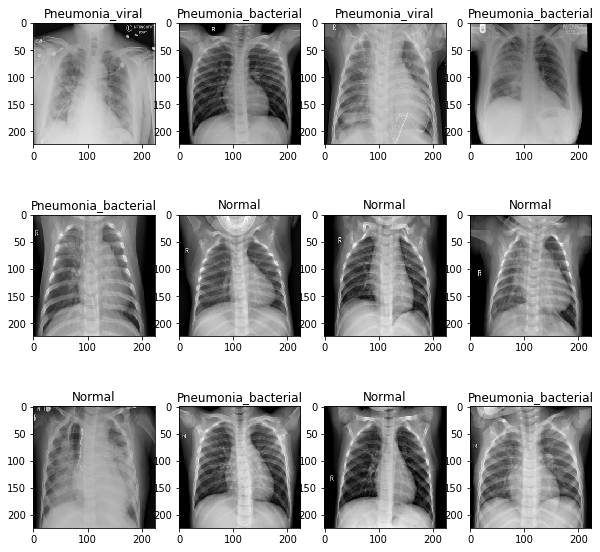

In [12]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Covid19')
    elif np.argmax(Y_train[i]) == 1:
        ax.title.set_text('Normal')
    elif np.argmax(Y_train[i]) == 2:
        ax.title.set_text('Pneumonia_bacterial')
    elif np.argmax(Y_train[i]) == 3:
        ax.title.set_text('Pneumonia_viral')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [13]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2.5,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [14]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)
 
vgg      = VGG19(include_top=False, input_shape=input_shape)(inputs)

80150528/80134624 [==============================] - 1s 0us/step


In [15]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
outputs = GlobalAveragePooling2D()(vgg)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(256,activation='relu')(outputs) 
outputs = Dense(128,activation='relu')(outputs) 
outputs = Dropout(0.2)(outputs)
outputs = Dense(4, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/MyDrive/writing.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [17]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
35/35 [==============================] - 69s 1s/step - loss: 1.5627 - accuracy: 0.2809 - val_loss: 2.4587 - val_accuracy: 0.2456 - lr: 1.0000e-04
Epoch 2/200
35/35 [==============================] - 39s 1s/step - loss: 1.4221 - accuracy: 0.3301 - val_loss: 3.2340 - val_accuracy: 0.2351 - lr: 1.0000e-04
Epoch 3/200
35/35 [==============================] - 39s 1s/step - loss: 1.4071 - accuracy: 0.3117 - val_loss: 1.8865 - val_accuracy: 0.2947 - lr: 1.0000e-04
Epoch 4/200
35/35 [==============================] - 39s 1s/step - loss: 1.4147 - accuracy: 0.3196 - val_loss: 1.5542 - val_accuracy: 0.2386 - lr: 1.0000e-04
Epoch 5/200
35/35 [==============================] - 39s 1s/step - loss: 1.3526 - accuracy: 0.3960 - val_loss: 1.8124 - val_accuracy: 0.2140 - lr: 1.0000e-04
Epoch 6/200
35/35 [==============================] - 39s 1s/step - loss: 1.3771 - accuracy: 0.3547 - val_loss: 3.2195 - val_accuracy: 0.2351 - lr: 1.0000e-04
Epoch 7/200
35/35 [==============================] -

Confusion matrix, without normalization
[[20  0  0  0]
 [14 35 17 21]
 [ 2  4 55 14]
 [ 8  1  7 54]]


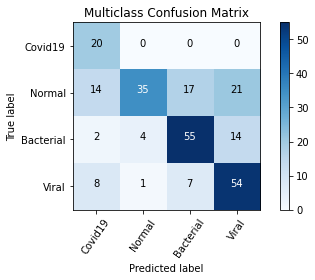

In [18]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Covid19','Normal','Bacterial','Viral']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

In [21]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=3)
auc=metrics.auc(fpr, tpr)
auc

0.7739010989010989

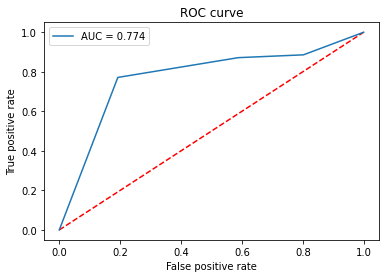

In [22]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

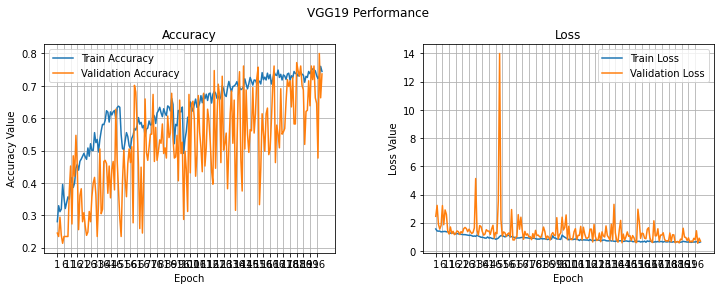

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG19 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,201))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 201, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 201, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [20]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Covid19','Normal','Bacterial','Viral']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     Covid19       0.45      1.00      0.62        20
      Normal       0.88      0.40      0.55        87
   Bacterial       0.70      0.73      0.71        75
       Viral       0.61      0.77      0.68        70

    accuracy                           0.65       252
   macro avg       0.66      0.73      0.64       252
weighted avg       0.71      0.65      0.64       252

